In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras

import gc

from numpy import save, load


In [2]:
#fds.list_builders()

In [3]:
ds = 'malaria'
builder = tfds.builder(ds)
info = builder.info
info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images
    with equal instances of parasitized and uninfected cells from the thin blood 
    smear slide images of segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path='C:\\Users\\edmun\\tensorflow_datasets\\malaria\\1.0.0',
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward 
      improved malaria parasite detection in thin blood smear image

## Loading the data

In [4]:

ds_all, ds_all_info = tfds.load(name='malaria', split="train", shuffle_files=True, with_info=True)

train_ds, val_ds, test_ds = tfds.load(ds, split=['train[:20%]', 'train[70%:75%]', 'train[85%:90%]'])


In [5]:
print("Number of prediction classes:", ds_all_info.features['label'].num_classes)
print("Prediction classes:", ds_all_info.features['label'].names)

Number of prediction classes: 2
Prediction classes: ['parasitized', 'uninfected']


In [6]:
no_train = tf.data.experimental.cardinality(train_ds).numpy()
no_valid = tf.data.experimental.cardinality(val_ds).numpy()
no_test = tf.data.experimental.cardinality(test_ds).numpy()

In [7]:
print("Number of training images:", no_train)
print("Number of validating images:", no_valid)
print("Number of testing images:", no_test)

Number of training images: 5512
Number of validating images: 1377
Number of testing images: 1378


## Showing Examples

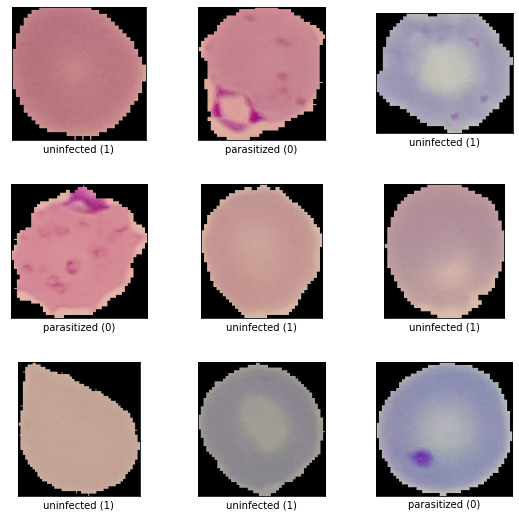

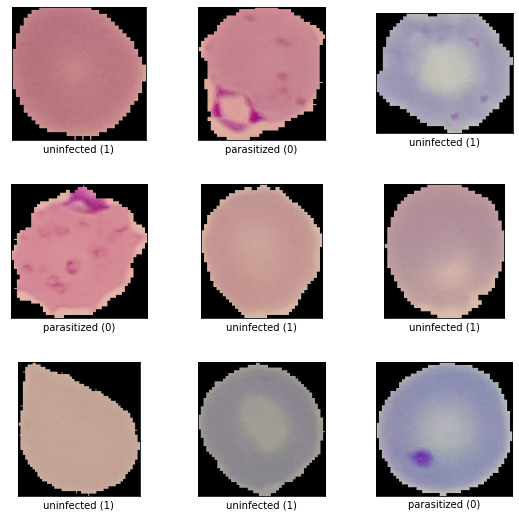

In [8]:
tfds.show_examples(ds_all, info)

## Data Preparation   

Extracting the images

In [9]:
train_images = np.array([example['image'].numpy() for example in train_ds] , dtype="object")
train_labels = [example['label'] for example in train_ds]

val_images = np.array([example['image'].numpy() for example in val_ds] , dtype="object")
val_labels = [example['label'] for example in val_ds]

test_images = np.array([example['image'].numpy() for example in test_ds] , dtype="object")
test_labels = [example['label'] for example in test_ds]

Checking to see the consistency in image lengths. 


In [10]:
c = 0
for i in train_images:
    print(i.shape)
    c+=1
    if c > 25:
        break

(103, 103, 3)
(106, 121, 3)
(139, 142, 3)
(130, 118, 3)
(121, 109, 3)
(127, 121, 3)
(166, 151, 3)
(145, 139, 3)
(139, 142, 3)
(172, 145, 3)
(157, 166, 3)
(115, 88, 3)
(115, 136, 3)
(142, 136, 3)
(115, 133, 3)
(124, 127, 3)
(136, 121, 3)
(118, 118, 3)
(124, 106, 3)
(142, 181, 3)
(139, 133, 3)
(127, 130, 3)
(157, 136, 3)
(136, 151, 3)
(106, 118, 3)
(130, 127, 3)


The images are of different lengths. We need to pad/crop the images to achieve images of same lengths.

In [11]:
gc.collect()

65

In [12]:
try:
    train_images = load('train_images.npy',  allow_pickle=True)
    print("Numpy file found and loaded.")
except FileNotFoundError:
    print("Training Images Numpy file not yet created. Creating one now.")
    for i in range(len(train_images)):
        train_images[i] = tf.image.resize_with_crop_or_pad(train_images[i], 200, 200)
        train_images[i] = tf.image.convert_image_dtype(train_images[i], tf.float64)
        train_images[i] = tf.reshape(train_images[i], [200,200,3])
    train_images = tf.constant(tf.stack([i.numpy() for i in train_images])).numpy()
    save('train_images.npy', train_images)

Numpy file found and loaded.


In [13]:
train_labels = tf.constant(tf.stack([i.numpy() for i in train_labels])).numpy()

In [14]:
gc.collect()

11

In [15]:
try:
    val_images = load('val_images.npy',  allow_pickle=True)
    print("Numpy file found and loaded.")
except FileNotFoundError:
    print("Validating Images Numpy file not yet created. Creating one now.")
    for i in range(len(val_images)):
        val_images[i] = tf.image.resize_with_crop_or_pad(val_images[i], 200, 200)
        val_images[i] = tf.image.convert_image_dtype(val_images[i], tf.float64)
        val_images[i] = tf.reshape(val_images[i], [200,200,3])
    val_images = tf.constant(tf.stack([i.numpy() for i in val_images])).numpy()
    save('val_images.npy', val_images)

Numpy file found and loaded.


In [16]:
val_labels = tf.constant(tf.stack([i.numpy() for i in val_labels])).numpy()

In [17]:
try:
    test_images = load('test_images.npy',  allow_pickle=True)
    print("Numpy file found and loaded.")
except FileNotFoundError:
    print("Testing Images Numpy file not yet created. Creating one now.")
    for i in range(len(test_images)):
        test_images[i] = tf.image.resize_with_crop_or_pad(test_images[i], 200, 200)
        test_images[i] = tf.image.convert_image_dtype(test_images[i], tf.float64)
        test_images[i] = tf.reshape(test_images[i], [200,200,3])
    test_images = tf.constant(tf.stack([i.numpy() for i in test_images])).numpy()
    save('test_images.npy', test_images)

Numpy file found and loaded.


In [18]:
test_labels = tf.constant(tf.stack([i.numpy() for i in test_labels])).numpy()

In [19]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("uninfected")
        else:
            plt.title("parasitized")
        plt.axis("off")

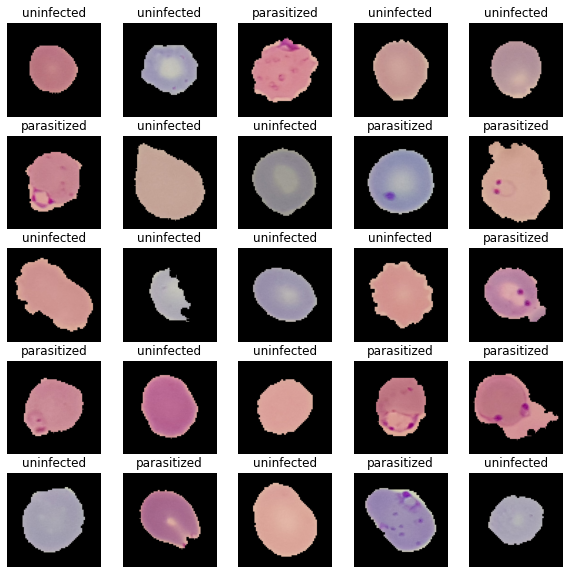

In [20]:
show_batch(train_images, train_labels)

## Model Building

In [21]:
gc.collect()

58074

## Basic Model

In [22]:
model = keras.Sequential([
  keras.layers.Flatten(),
  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dense(256, activation='relu'),
  keras.layers.Dense(2, activation='softmax')
])


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images,train_labels, epochs=5, batch_size=32)

Epoch 1/5
173/173 [==============================] - 40s 224ms/step - loss: 3.2596 - accuracy: 0.5441
Epoch 2/5
173/173 [==============================] - 39s 225ms/step - loss: 0.7162 - accuracy: 0.6014
Epoch 3/5
173/173 [==============================] - 39s 224ms/step - loss: 0.6870 - accuracy: 0.6174
Epoch 4/5
173/173 [==============================] - 39s 223ms/step - loss: 0.6543 - accuracy: 0.6401
Epoch 5/5
173/173 [==============================] - 38s 221ms/step - loss: 0.6612 - accuracy: 0.6177


In [39]:
model = keras.Sequential([
   keras.layers.AveragePooling2D(6,3, input_shape=(200,200,3)),
   keras.layers.Conv2D(256, 3, activation='relu'),
   keras.layers.Conv2D(64, 3, activation='relu'),
   keras.layers.MaxPool2D(2,2),
   keras.layers.Dropout(0.5),
   keras.layers.Flatten(),
   keras.layers.Dense(128, activation='relu'),
   keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=5, batch_size=32)

Epoch 1/5
 18/173 [==>...........................] - ETA: 2:02 - loss: 0.7425 - accuracy: 0.5312

KeyboardInterrupt: 

In [27]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [30]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(200, 200, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [31]:
model = build_model()

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=tf.keras.metrics.AUC(name='auc')
)

In [32]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("malaria_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     restore_best_weights=True)

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [41]:
history = model.fit(
    train_images, train_labels, epochs=20, batch_size = 32
)

Epoch 1/20
173/173 [==============================] - 143s 824ms/step - loss: 0.6857 - accuracy: 0.5396
Epoch 2/20
173/173 [==============================] - 144s 830ms/step - loss: 0.6709 - accuracy: 0.5876
Epoch 3/20
173/173 [==============================] - 145s 835ms/step - loss: 0.6359 - accuracy: 0.6431
Epoch 4/20
173/173 [==============================] - 144s 833ms/step - loss: 0.5125 - accuracy: 0.7640
Epoch 5/20
173/173 [==============================] - 148s 853ms/step - loss: 0.4727 - accuracy: 0.7859
Epoch 6/20
173/173 [==============================] - 168s 972ms/step - loss: 0.3015 - accuracy: 0.8843
Epoch 7/20
173/173 [==============================] - 166s 959ms/step - loss: 0.2444 - accuracy: 0.9073
Epoch 8/20
173/173 [==============================] - 144s 831ms/step - loss: 0.2105 - accuracy: 0.9242
Epoch 9/20
173/173 [==============================] - 145s 837ms/step - loss: 0.1850 - accuracy: 0.9292
Epoch 10/20
173/173 [==============================] - 150s 866m

In [43]:
model.evaluate(test_images,test_labels)

44/44 [==============================] - 7s 159ms/step - loss: 0.2896 - accuracy: 0.9238


[0.289563924074173, 0.9238026142120361]